# Objective

Investigate how much the original images are shifted in the x and y directions when they get aligned with the background images.

# Dataset

All fields of view that have background and original images from in the 29 experiment folders starting with 2020-11-13 in https://drive.google.com/drive/u/5/folders/1If1li3I-XagdB-3uEBQDegKDhGichiLx. (The experiment folders before 2020-11-13 lack background images.)

# Method

For each experiment:
- if a folder called “CCI Images” does not exist, skip this experiment
- for each img_set in CCI Images:
    - if there are no files that start with “background-“, skip this img_set
    - if there are no files that start with “image-”, skip this img_set
    - for each "background-" image in the img_set:
        - record y_shift and x_shift
        - save the aligned image (for reference later as needed)
        
# Contents

- Code that was run
- Visualize shifts
    - Median, mean, stdev
    - Plots
        - Scatter plot of y shifts vs. x shifts
        - Scatter plot of y shifts vs. x shifts, zoomed in
        - Histogram of x shifts
        - Histogram of x shifts, zoomed in
        - Histogram of y shifts
        - Histogram of y shifts, zoomed in
- Check images with large x shift (x_shift > 200)
- Check images with large y shift (y_shift > 200)

# General observations

- Most images are shifted no more than about 10 pixels horizontally or vertically during alignment
- Images that are shifted a lot tend to have bubbles.
- Bubbles tend to cause poor alignment.

In [5]:
from skimage.io import imread, imsave
from skimage import feature, transform
from scipy.ndimage import fourier_shift
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os.path import isdir, isfile, join

# Ran this

(Ran this code separate in get_shifts.py)

In [84]:
def get_dirs(mypath):
    return sorted([f for f in os.listdir(mypath) if isdir(join(mypath, f))])
def get_files(mypath):
    return sorted([f for f in os.listdir(mypath) if isfile(join(mypath, f))])

In [3]:
columns = ['experiment', 'img_set', 'filename', 'y_shift', 'x_shift']
df_result = pd.DataFrame(columns=columns)
experiments = get_dirs('./cci/')

for experiment_ind in range(len(experiments)):
    print('experiment: %s / %s' % (str(experiment_ind), str(len(experiments))))
    experiment = experiments[experiment_ind]
    
    cci_images_path = join('./cci/', experiment, 'CCI Images')
    img_sets = get_dirs(cci_images_path)
        
    for img_set_ind in range(len(img_sets)):
        print('\timg_set: %s / %s' % (str(img_set_ind), str(len(img_sets))))
        img_set = img_sets[img_set_ind]
        
        img_set_path = join(cci_images_path, img_set)
        files = get_files(img_set_path)
        background_imgs = [f for f in files if 'background-' in f]
        if len(background_imgs)==0: continue
        imgs_to_align = [f for f in files if 'image-' in f]
        if len(imgs_to_align)==0: continue
        names = [f[11:-4] for f in background_imgs]
        
        for name_ind in range(len(names)):
            print('\t\tname: %s / %s' % (str(name_ind), str(len(names))))
            name = names[name_ind]
            
            bg = imread(join(img_set_path, 'background-%s.tif' % name))
            imgToAlign = imread(join(img_set_path, 'image-%s.tif' % name))
            shift, error, diffphase = feature.register_translation(bg, imgToAlign)
            y_shift, x_shift = shift
            alignedImage = fourier_shift(np.fft.fftn(imgToAlign), shift)
            alignedImage = np.fft.ifftn(alignedImage)
            alignedImage = alignedImage.real
            imsave(join(img_set_path, 'aligned-%s.tif' % name), alignedImage.astype(np.uint16))
            row = {'experiment': experiment,
                   'img_set': img_set,
                   'filename': name,
                   'y_shift': y_shift,
                   'x_shift': x_shift,
                  }
            df_result = df_result.append(row, ignore_index=True)
df_result.to_csv('shifts.csv', index=None)

# Visualize shifts

Load data from the result of get_shifts.py

In [6]:
df_full = pd.read_csv('shifts.csv')

In [7]:
df_full

experiment          img_set  \
0     20201113_CCI_Normalization_microscpy_split_bac...  20201113-145812   
1     20201113_CCI_Normalization_microscpy_split_bac...  20201113-145812   
2     20201113_CCI_Normalization_microscpy_split_bac...  20201113-145812   
3     20201113_CCI_Normalization_microscpy_split_bac...  20201113-145812   
4     20201113_CCI_Normalization_microscpy_split_bac...  20201113-145812   
...                                                 ...              ...   
2591  20210506_CCI_Microscopy_Normalization_Het_HEPE...  20210506-162622   
2592  20210506_CCI_Microscopy_Normalization_Het_HEPE...  20210506-162622   
2593  20210506_CCI_Microscopy_Normalization_Het_HEPE...  20210506-162622   
2594  20210506_CCI_Microscopy_Normalization_Het_HEPE...  20210506-162622   
2595  20210506_CCI_Microscopy_Normalization_Het_HEPE...  20210506-162622   

               filename  y_shift  x_shift  
0     20201113-145812-0      7.0      1.0  
1     20201113-145812-1     13.0     -3.0  
2     20201113-145812-2     22.0     -4.0  
3     20201113-145812-3     17.0    -10.0  
4     20201113-145812-4     11.0    -16.0  
...                 ...      ...      ...  
2591  20210506-162622-3      7.0      7.0  
2592  20210506-162622-4      6.0      3.0  
2593  20210506-162622-5      7.0     -1.0  
2594  20210506-162622-6     -3.0      4.0  
2595  20210506-162622-7      0.0      3.0  

[2596 rows x 5 columns]

## Median, Mean, Stdev

In [16]:
np.median(df_full.x_shift), np.mean(df_full.x_shift), np.std(df_full.x_shift)

(2.0, 5.2184129429892145, 39.73989565376541)

In [17]:
np.median(df_full.y_shift), np.mean(df_full.y_shift), np.std(df_full.y_shift)

(-1.0, -2.4842064714946073, 29.951503897057037)

## Plots

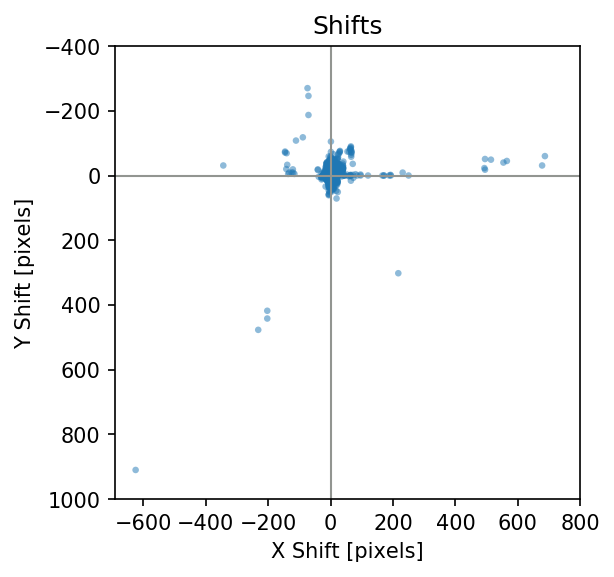

In [8]:
plt.figure(dpi=150, figsize=(4,4))
plt.axvline(0, c='xkcd:gray', lw=1)
plt.axhline(0, c='xkcd:gray', lw=1)
plt.scatter(df_full.x_shift, df_full.y_shift, edgecolor='None', s=10, alpha=0.5)
plt.gca().invert_yaxis()
plt.xticks(range(-600, 801, 200))
plt.yticks(range(-400, 1001, 200))
plt.xlabel('X Shift [pixels]')
plt.ylabel('Y Shift [pixels]')
plt.title('Shifts')
plt.show()

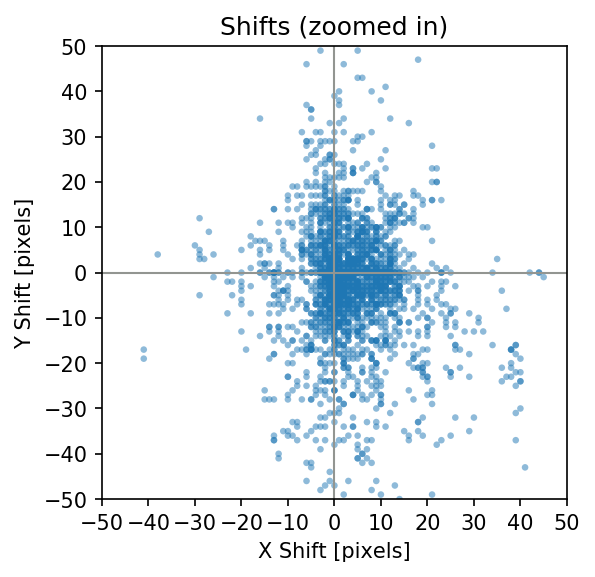

In [9]:
lim = 50
plt.figure(dpi=150, figsize=(4,4))
plt.axvline(0, c='xkcd:gray', lw=1)
plt.axhline(0, c='xkcd:gray', lw=1)
plt.scatter(df_full.x_shift, df_full.y_shift, edgecolor='None', s=10, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xticks(range(-lim, lim+1, 10))
plt.yticks(range(-lim, lim+1, 10))
plt.xlabel('X Shift [pixels]')
plt.ylabel('Y Shift [pixels]')
plt.title('Shifts (zoomed in)')
plt.show()

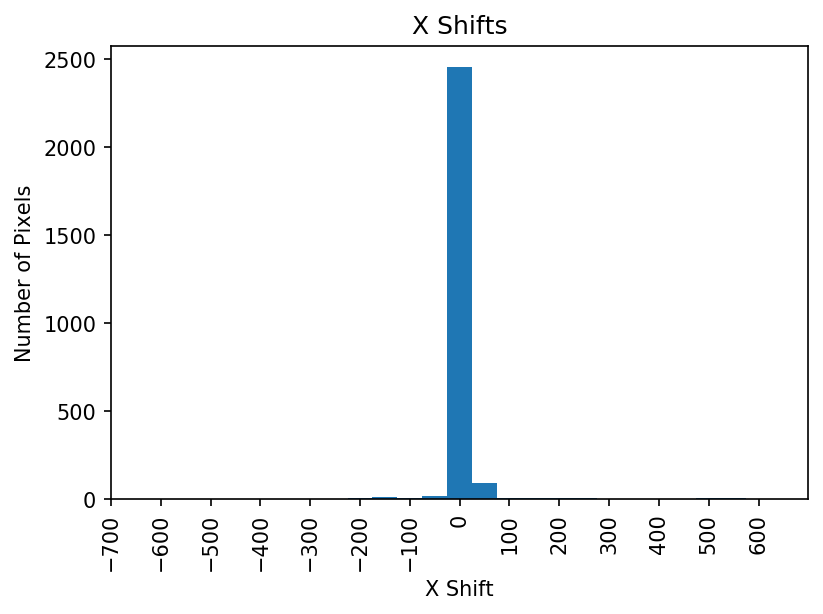

In [134]:
lim = 700
plt.figure(dpi=150)
plt.hist(df_full.x_shift, np.arange(-lim, lim, 50)-25)
plt.xlim(-lim, lim)
plt.xticks(np.arange(-lim, lim, 100), rotation=90)
plt.title('X Shifts')
plt.xlabel('X Shift')
plt.ylabel('Number of Pixels')
plt.show()

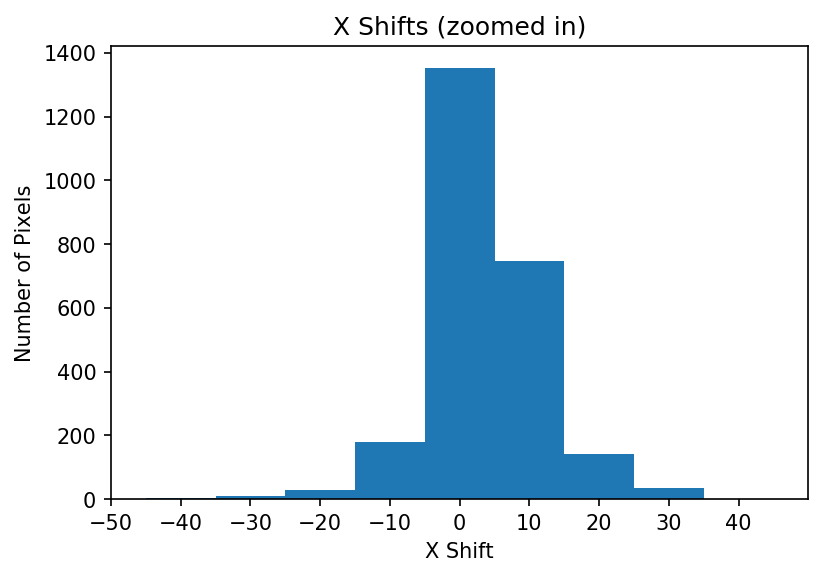

In [135]:
lim = 50
plt.figure(dpi=150)
plt.hist(df_full.x_shift, np.arange(-lim, lim, 10)-5)
plt.xlim(-lim, lim)
plt.xticks(np.arange(-lim, lim, 10))
plt.title('X Shifts (zoomed in)')
plt.xlabel('X Shift')
plt.ylabel('Number of Pixels')
plt.show()

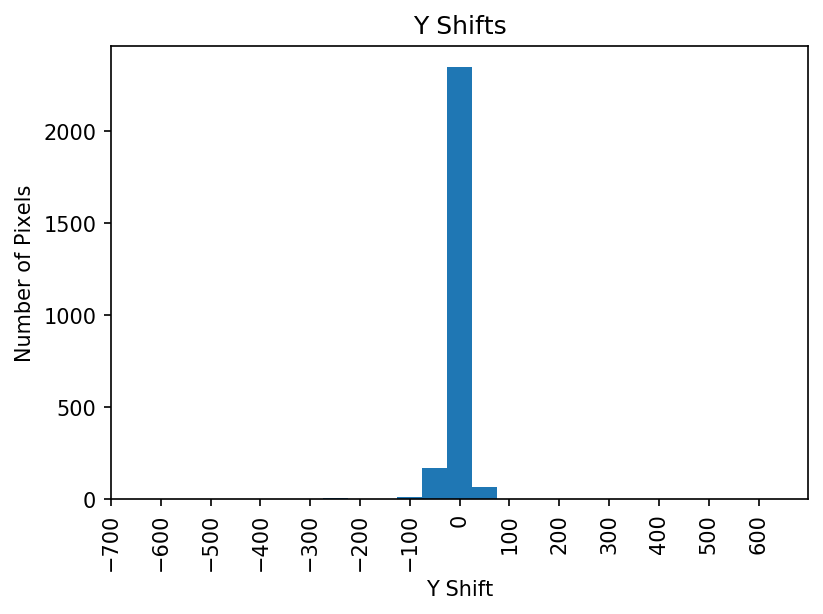

In [144]:
lim = 700
plt.figure(dpi=150)
plt.hist(df_full.y_shift, np.arange(-lim, lim, 50)-25)
plt.xlim(-lim, lim)
plt.xticks(np.arange(-lim, lim, 100), rotation=90)
plt.title('Y Shifts')
plt.xlabel('Y Shift')
plt.ylabel('Number of Pixels')
plt.show()

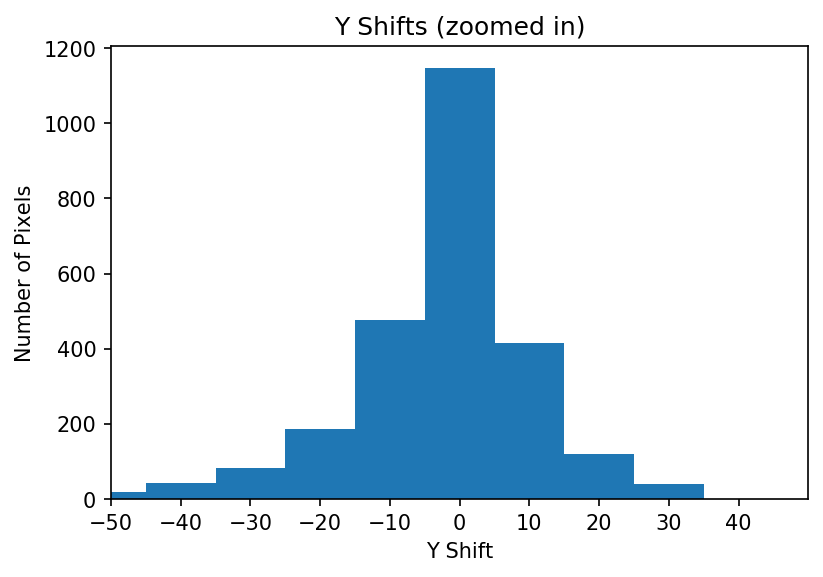

In [145]:
lim = 50
plt.figure(dpi=150)
plt.hist(df_full.y_shift, np.arange(-lim, lim, 10)-5)
plt.xlim(-lim, lim)
plt.xticks(np.arange(-lim, lim, 10))
plt.title('Y Shifts (zoomed in)')
plt.xlabel('Y Shift')
plt.ylabel('Number of Pixels')
plt.show()

# Check images with large X shift

--------------------------
20201119-170233-4
x_shift: 231.0
y_shift: -9.0
./cci/20201119_CCI_Normalization_microscopy_split_background_subtracted/CCI Images/20201119-170233/image-20201119-170233-4.tif


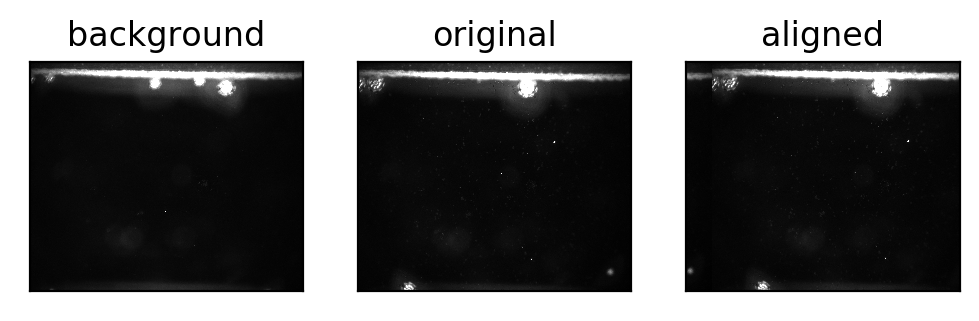

--------------------------
20201207-183917-3
x_shift: -344.0
y_shift: -31.0
./cci/20201207_CCI_Normalization_Microscopy_Split_4C/CCI Images/20201207-183917/image-20201207-183917-3.tif


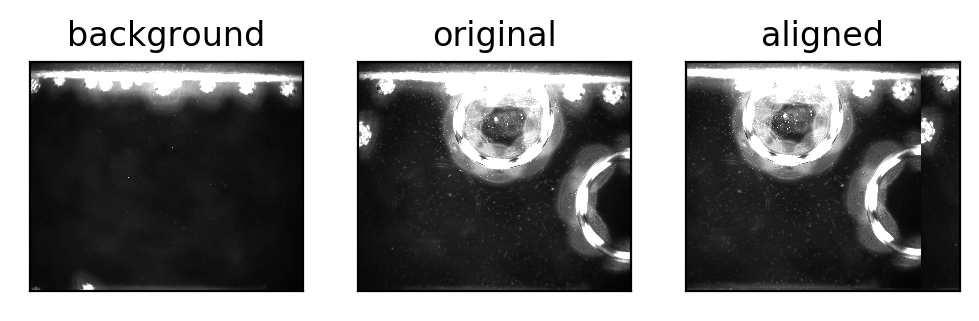

--------------------------
20201216-155440-2
x_shift: 250.0
y_shift: 0.0
./cci/20201216_CCI_Normalization_Microscopy_Split_roomtemp_HEPES_heterogenous/CCI Images/20201216-155440/image-20201216-155440-2.tif


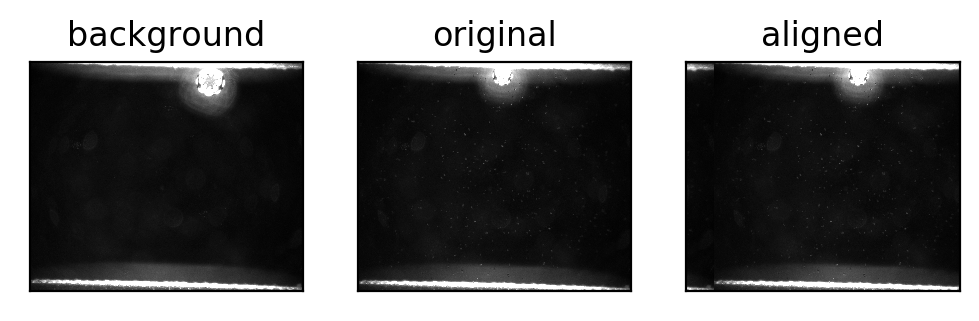

--------------------------
20210126-141955-2
x_shift: 217.0
y_shift: 302.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-141955/image-20210126-141955-2.tif


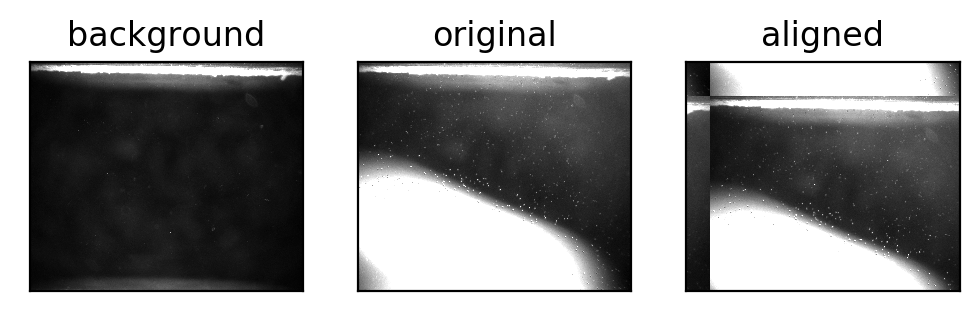

--------------------------
20210126-142929-6
x_shift: -203.0
y_shift: 442.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-142929/image-20210126-142929-6.tif


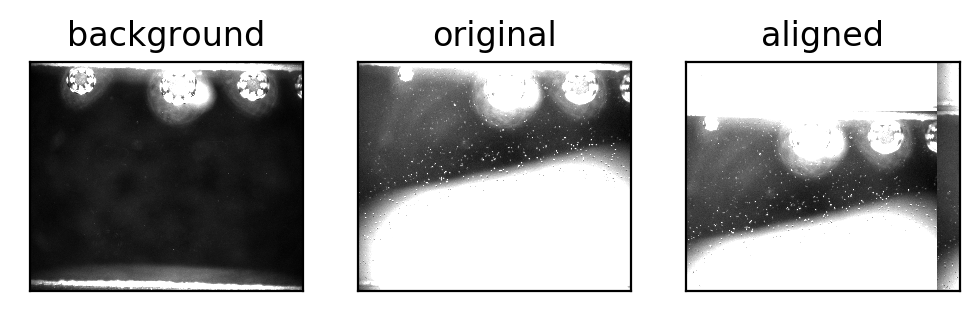

--------------------------
20210126-143903-6
x_shift: -203.0
y_shift: 418.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-143903/image-20210126-143903-6.tif


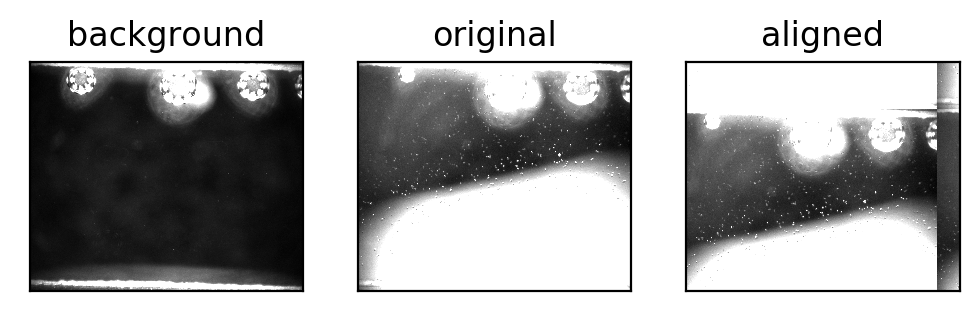

--------------------------
20210126-144836-6
x_shift: -232.0
y_shift: 477.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-144836/image-20210126-144836-6.tif


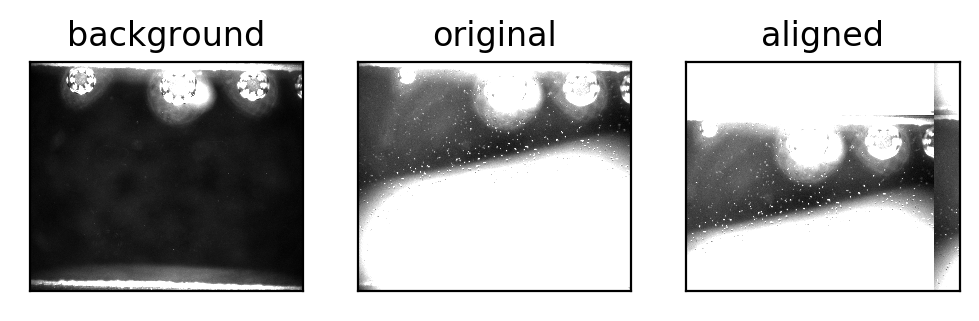

--------------------------
20210224-170121-7
x_shift: 678.0
y_shift: -31.0
./cci/20210224_DMEM_RT/CCI Images/20210224-170121/image-20210224-170121-7.tif


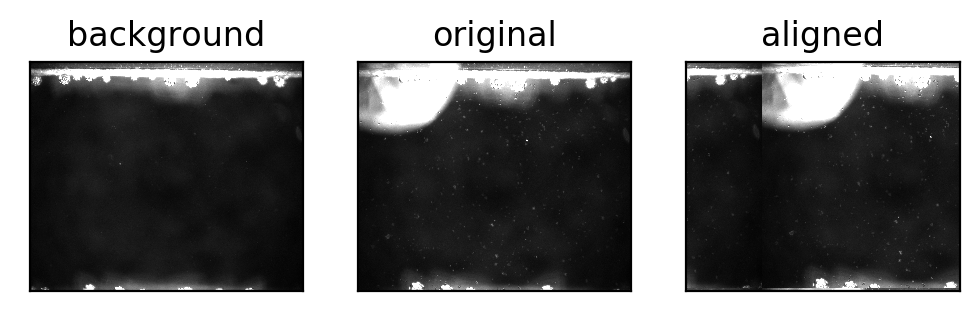

--------------------------
20210224-171120-7
x_shift: 687.0
y_shift: -60.0
./cci/20210224_DMEM_RT/CCI Images/20210224-171120/image-20210224-171120-7.tif


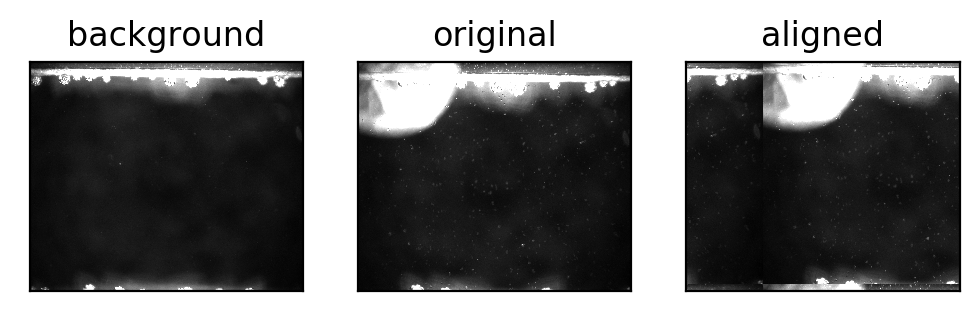

--------------------------
20210224-172118-7
x_shift: 514.0
y_shift: -49.0
./cci/20210224_DMEM_RT/CCI Images/20210224-172118/image-20210224-172118-7.tif


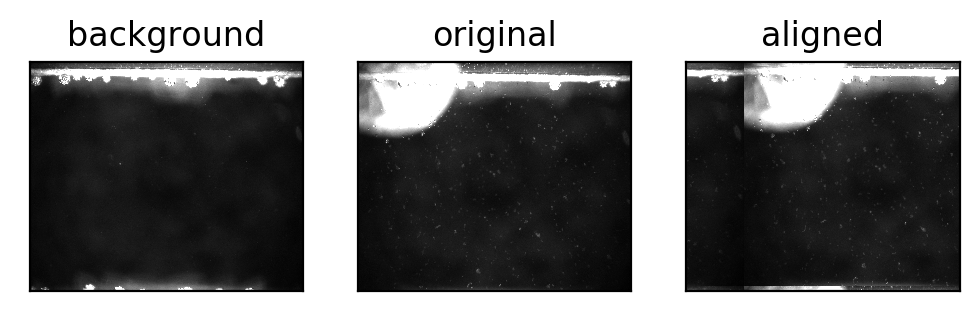

--------------------------
20210224-173117-7
x_shift: 495.0
y_shift: -18.0
./cci/20210224_DMEM_RT/CCI Images/20210224-173117/image-20210224-173117-7.tif


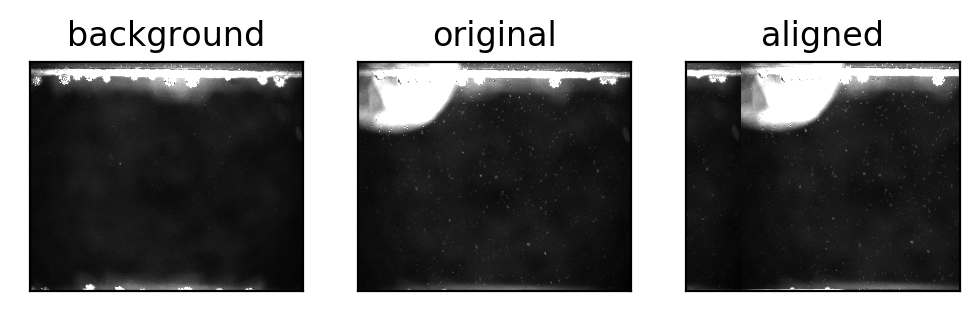

--------------------------
20210224-174113-7
x_shift: 493.0
y_shift: -23.0
./cci/20210224_DMEM_RT/CCI Images/20210224-174113/image-20210224-174113-7.tif


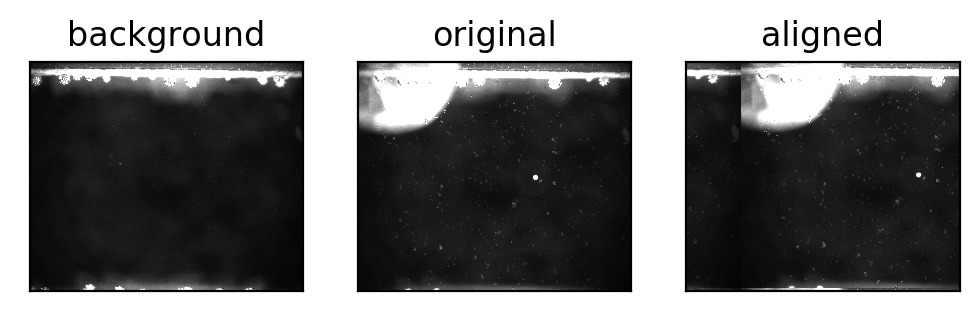

--------------------------
20210224-175109-7
x_shift: 495.0
y_shift: -51.0
./cci/20210224_DMEM_RT/CCI Images/20210224-175109/image-20210224-175109-7.tif


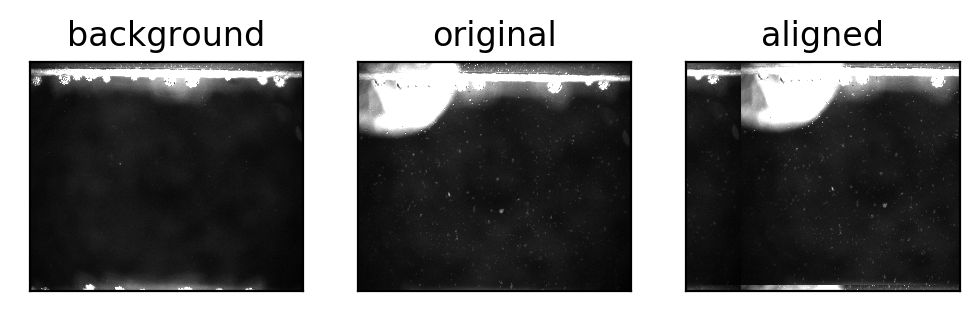

--------------------------
20210224-180105-7
x_shift: 554.0
y_shift: -40.0
./cci/20210224_DMEM_RT/CCI Images/20210224-180105/image-20210224-180105-7.tif


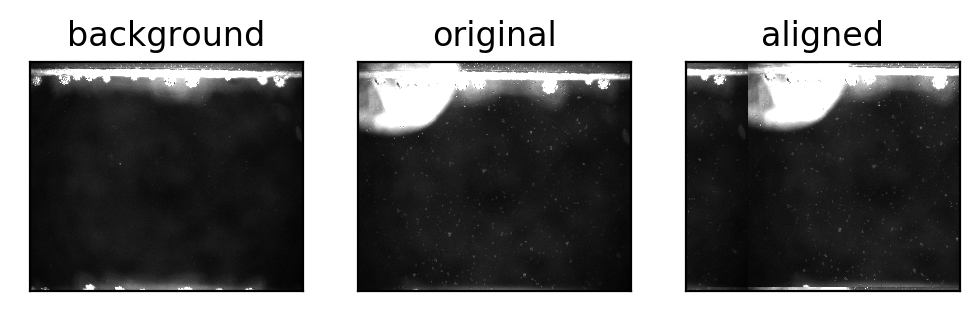

--------------------------
20210224-181101-7
x_shift: 565.0
y_shift: -45.0
./cci/20210224_DMEM_RT/CCI Images/20210224-181101/image-20210224-181101-7.tif


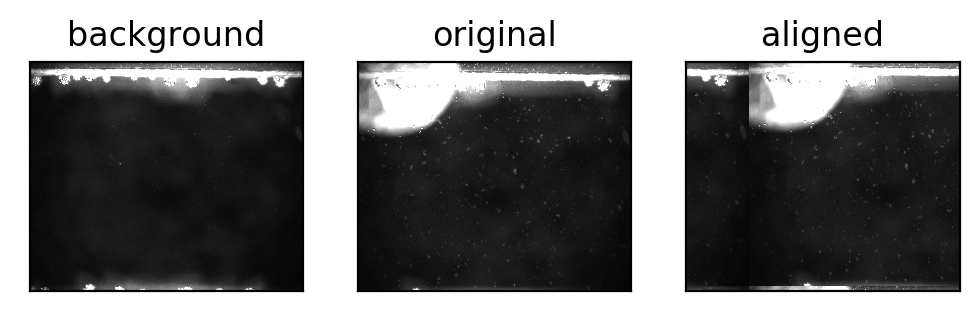

--------------------------
20210225-161228-6
x_shift: -625.0
y_shift: 910.0
./cci/20210225_DMEM_4C/CCI Images/20210225-161228/image-20210225-161228-6.tif


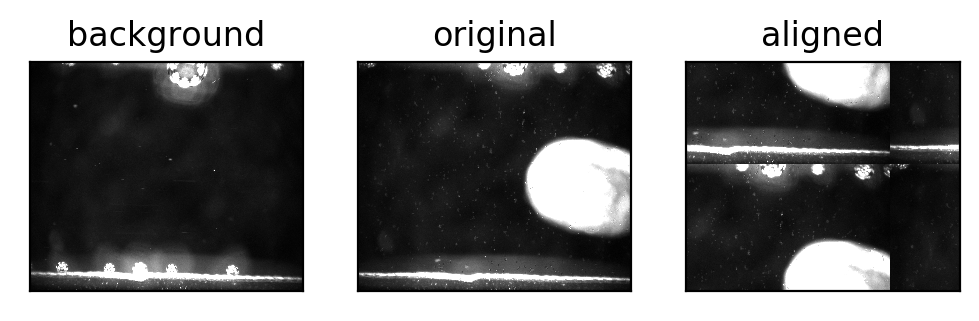

In [140]:
df = df_full[abs(df_full.x_shift) > 200]

for ind in df.index:
    print('--------------------------')
    print(df.filename[ind])
    print('x_shift: %s' % df.x_shift[ind])
    print('y_shift: %s' % df.y_shift[ind])
    print(join('./cci/', df.experiment[ind], 'CCI Images',
                          df.img_set[ind], 'image-%s.tif' % df.filename[ind]))
    
    bg = imread(join('./cci/', df.experiment[ind], 'CCI Images',
                     df.img_set[ind], 'background-%s.tif' % df.filename[ind]))
    aligned = imread(join('./cci/', df.experiment[ind], 'CCI Images',
                          df.img_set[ind], 'aligned-%s.tif' % df.filename[ind]))
    og = imread(join('./cci/', df.experiment[ind], 'CCI Images',
                          df.img_set[ind], 'image-%s.tif' % df.filename[ind]))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=200)
    ax1.imshow(bg, cmap='gray')
    ax1.set_title('background')
    ax2.imshow(og, cmap='gray')
    ax2.set_title('original')
    ax3.imshow(aligned, cmap='gray')
    ax3.set_title('aligned')
    for ax in [ax1, ax2, ax3]:
        ax.set_xticklabels(labels=[])
        ax.set_xticks(ticks=[])
        ax.set_yticklabels(labels=[])
        ax.set_yticks(ticks=[])
    plt.show()

# Check images with large Y shift

--------------------------
20210126-141955-2
x_shift: 217.0
y_shift: 302.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-141955/image-20210126-141955-2.tif


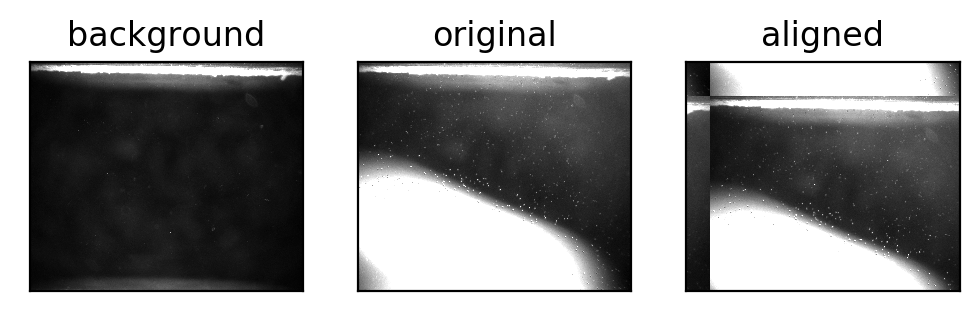

--------------------------
20210126-142929-6
x_shift: -203.0
y_shift: 442.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-142929/image-20210126-142929-6.tif


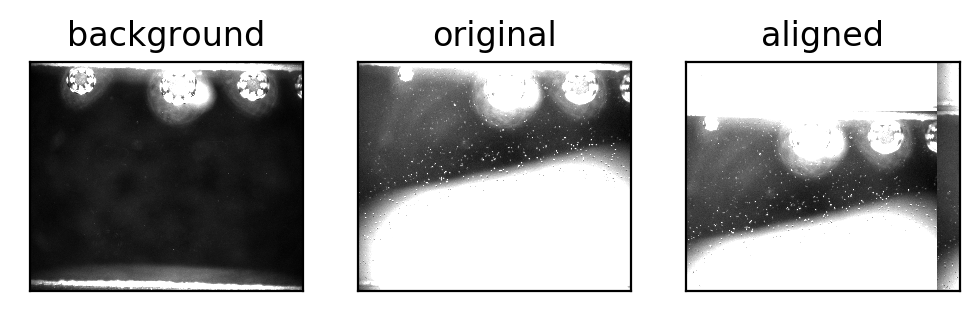

--------------------------
20210126-142929-7
x_shift: -71.0
y_shift: -246.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-142929/image-20210126-142929-7.tif


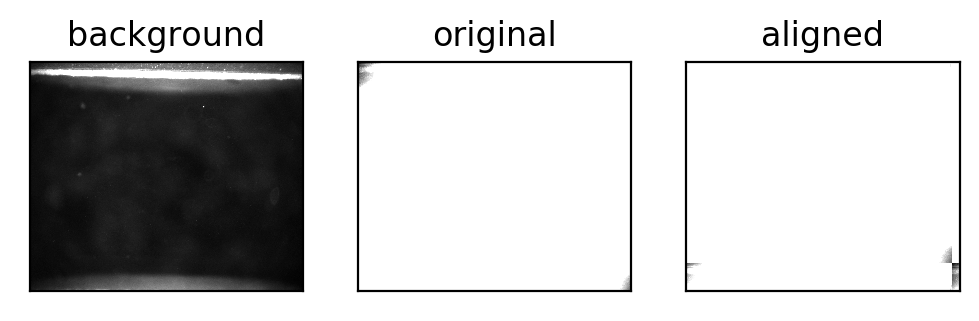

--------------------------
20210126-143903-6
x_shift: -203.0
y_shift: 418.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-143903/image-20210126-143903-6.tif


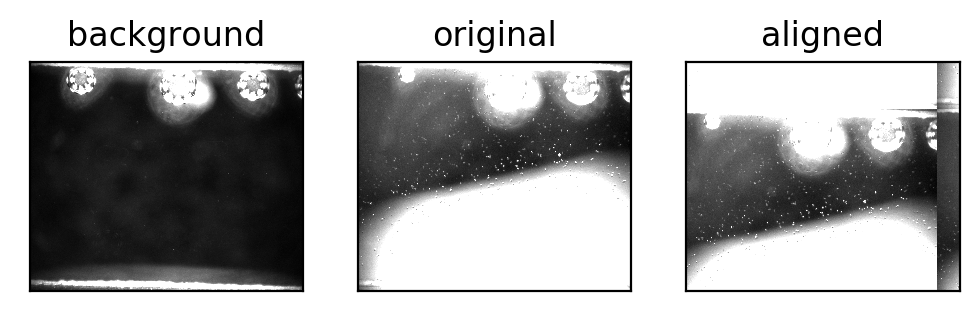

--------------------------
20210126-143903-7
x_shift: -74.0
y_shift: -270.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-143903/image-20210126-143903-7.tif


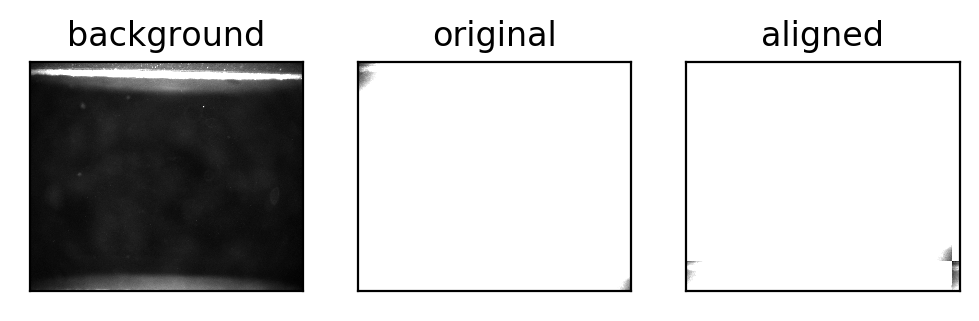

--------------------------
20210126-144836-6
x_shift: -232.0
y_shift: 477.0
./cci/20210126_CCI_Normalization_V2_HEPES_RT/CCI Images/20210126-144836/image-20210126-144836-6.tif


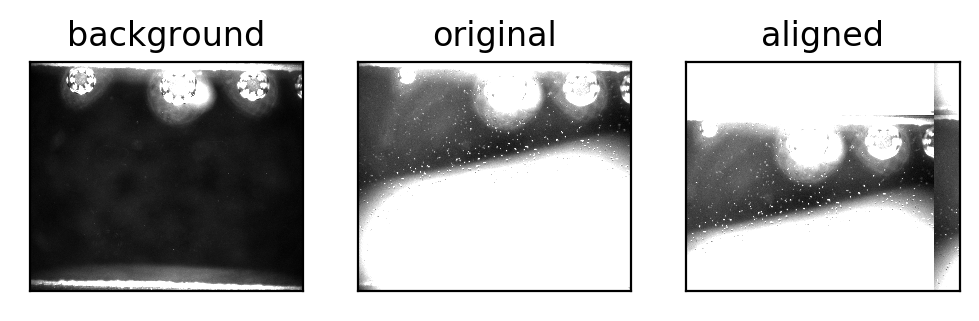

--------------------------
20210225-161228-6
x_shift: -625.0
y_shift: 910.0
./cci/20210225_DMEM_4C/CCI Images/20210225-161228/image-20210225-161228-6.tif


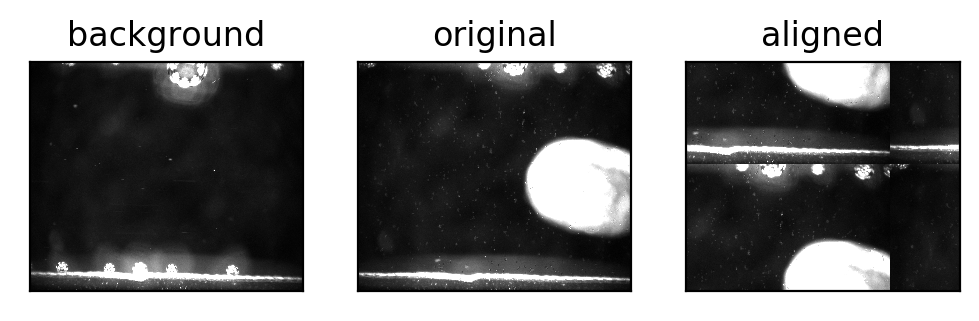

In [143]:
df = df_full[abs(df_full.y_shift) > 200]

for ind in df.index:
    print('--------------------------')
    print(df.filename[ind])
    print('x_shift: %s' % df.x_shift[ind])
    print('y_shift: %s' % df.y_shift[ind])
    print(join('./cci/', df.experiment[ind], 'CCI Images',
                          df.img_set[ind], 'image-%s.tif' % df.filename[ind]))
    
    bg = imread(join('./cci/', df.experiment[ind], 'CCI Images',
                     df.img_set[ind], 'background-%s.tif' % df.filename[ind]))
    aligned = imread(join('./cci/', df.experiment[ind], 'CCI Images',
                          df.img_set[ind], 'aligned-%s.tif' % df.filename[ind]))
    og = imread(join('./cci/', df.experiment[ind], 'CCI Images',
                          df.img_set[ind], 'image-%s.tif' % df.filename[ind]))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=200)
    ax1.imshow(bg, cmap='gray')
    ax1.set_title('background')
    ax2.imshow(og, cmap='gray')
    ax2.set_title('original')
    ax3.imshow(aligned, cmap='gray')
    ax3.set_title('aligned')
    for ax in [ax1, ax2, ax3]:
        ax.set_xticklabels(labels=[])
        ax.set_xticks(ticks=[])
        ax.set_yticklabels(labels=[])
        ax.set_yticks(ticks=[])
    plt.show()